# Import des librairies

In [1]:
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import pandas as pd
import Levenshtein as lev
from concurrent import futures
from IPython.display import clear_output
#from selenium.webdriver.support.ui import WebDriverWait
#from selenium.webdriver.support import expected_conditions as EC

In [9]:
import pandas as pd 
from IPython.display import clear_output
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import csv
import numpy as np
import re
from tqdm import tqdm
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from concurrent import futures
import dateparser
import urllib

import warnings
warnings.filterwarnings('ignore')

#Matplotlib and Seaborn parameters : 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques


data_path="Data/"#Chemin du dossier pour enregistrer le fichier csv

In [3]:
def check_nan(df):
    for i in df.columns.tolist():
        print("Valeurs nan dans "+str(i)+" : "+str(df[i].isna().sum()))
        
def check_unique(df):
    for i in df.columns.tolist():
        print("Valeurs uniques dans "+str(i)+" : "+str(df[i].nunique()))

# Chargement des données déjà existantes

In [38]:
movie_csv = pd.read_csv(data_path+'data_allocine_scrapping_sens_critique.csv')
movie_csv['realisateurs'] = movie_csv['realisateurs'].apply(lambda data : eval(str(data)) if str(data)!="nan" else [] )
ids = list(movie_csv.id)
titres = list(movie_csv.titre)
dates = list(movie_csv.annee_sortie)
reals = list(movie_csv.realisateurs)
movie_csv

,id,titre,date_sortie,realisateurs,annee_sortie
0,178014,avatar : la voie de l'eau,2022-12-14,[James Cameron],2022
1,281293,les banshees d'inisherin,2022-12-28,[Martin McDonagh],2022
2,289305,tempête,2022-12-21,[Christian Duguay],2022
3,266320,m3gan,2022-12-28,[Gerard Johnstone],2022
4,288544,le tourbillon de la vie,2022-12-21,[Olivier Treiner],2022
...,...,...,...,...,...
19877,275748,o fim do mundo,2022-04-06,[Basil Da Cunha],2022
19878,277796,acceleration,2021-07-21,"[Michael Merino, Daniel Zirilli]",2021
19879,280139,a perfect family,2020-08-19,[Malou Leth Reymann],2020
19880,281034,jagame thandhiram,2021-06-18,[Karthik Subbaraj],2021


# Scrapping des ids des films sur senscritique

In [39]:
def find_on_page(xpath):
    #print('SEARCHING ' + xpath)
    while True:
        try:
            box = driver.find_element(By.XPATH, xpath)
            #box = driver.find_element(By.CSS_SELECTOR, xpath)
            #print('SUCCESS')
            return box
        except:
            pass
        

## Fonctions

In [40]:
def first_connexion(headless=False) :
    options = webdriver.ChromeOptions()
    
    if headless==True : 
        options.add_argument('-headless')
        options.add_argument("--window-size=1920,1080")
    driver = webdriver.Chrome(ChromeDriverManager().install(),options=options)
    driver.get("https://www.senscritique.com/")
    
    #driver.get_screenshot_as_file("screenshot.png")
    if headless==False : 
        time.sleep(1)
        cookies_box = driver.find_element(By.ID, 'didomi-notice-agree-button')
        cookies_box.click()
    return driver

In [41]:
def format_key_words(movie_name) : 
    return urllib.parse.quote(movie_name)

In [42]:

def list_to_lower(list_strings) : 
    for i in range(len(list_strings)) : 
        list_strings[i]=list_strings[i].lower()
    return list_strings

#Renvoie le score de similarité entre 2 strings 
def string_similarity(name1, name2):
    distance = lev.distance(name1, name2)
    min_length = min(len(name1), len(name2))
    result = (min_length - distance) / min_length
    return result * (result>0)

#Calcul un score de similarité entre 2 années à partir de la distance en celles-ci
#On considère que s'il y a 3 années ou plus d'écart le score est de 0
def year_similarity(year1, year2) : 
    max=5
    dif= abs(year1-year2)/max
    score= 1- (dif)
    return score * (score>0)

#Calcul le score de similarité relié aux acteurs présents dans les 2 films
def actors_similarity(list_actors1, list_actors2) : 
    if type(list_actors2) == str : # On s'assure que le deuxième paramètre est bien une liste
        list_actors2 = [list_actors2]
    if type(list_actors2) == tuple : 
        list_actors2 = list(list_actors2) 
    list_actors1 = list_to_lower(list_actors1)
    list_actors2 = list_to_lower(list_actors2)
    score=0
    for actor in list_actors1 : 
        if actor in list_actors2 : 
            score+=1/len(list_actors1)
        else : #Au cas où l'orthographe ne serait pas exactement la même
            score+=max([string_similarity(actor, actor2) for actor2 in list_actors2])/len(list_actors1)
    return score 


def score_similarite(name_imdb, year_imdb, actors_imdb, name, year, actors ) : 
    title_score= string_similarity(name_imdb.lower(), name.lower()) if name_imdb!="" else 0
    year_score = year_similarity(year_imdb, year) if ~np.isnan(year_imdb) else 0
    
    if actors_imdb != [] and len(actors)>0: 
        actors_score = actors_similarity(actors_imdb, actors)
    elif actors_imdb ==[] and len(actors)==0 : 
        actors_score = 1
    else : 
        actors_score= 0
    mean_score = (title_score+year_score+actors_score )/3
    return title_score, year_score, actors_score, mean_score

In [43]:
#GET MOVIE IDS AND RATINGS
def get_senscritique_data(driver, a_id, a_titre, a_date, a_reals):
    
    sc_id, sc_rating, sc_detailed_similarity, sc_mean_similarity = None, None, None, None
    detailed_scores = []
    similarity_scores = []
    rates = []
    
    
    mots_cles= format_key_words(a_titre)
    url =f"https://www.senscritique.com/search?query={mots_cles}&size=16"
    driver.get(url)

    time.sleep(1)
 
     
    movie_container_results = driver.find_elements(By.CSS_SELECTOR, "div[class='ExplorerProductCard__Container-sc-1fw1q8r-0 gkhVSD']")
    for i in range(5) : 
        time.sleep(1)
        movie_container_results = driver.find_elements(By.CSS_SELECTOR, "div[class='ExplorerProductCard__Container-sc-1fw1q8r-0 gkhVSD']")
        if len(movie_container_results)>0 : 
            break;
    
    if len(movie_container_results)>0 :
        for i in range(len(movie_container_results)):
            div = movie_container_results[i]        
            try :
                title_element = div.find_element(By.CSS_SELECTOR, "a[class='Text__SCText-sc-kgt5u3-0 Link__SecondaryLink-sc-1vfcbn2-1 jbJnwO eDKWEX']")
                title = title_element.text
            except :
                title = ""
            try:
                rating_element = div.find_element(By.CSS_SELECTOR, "*[data-testid='Rating']")
                rate = float(rating_element.text)
            except:
                rate = np.NAN
            try :
                desc_element = div.find_element(By.CSS_SELECTOR, "p[data-testid='product-explorer-creator']")
                desc = desc_element.text
            except:
                desc = "Film"
            desc = desc.split(' · ')
            if len(desc) == 2:
                date = int(desc[1])
            else:
                date = -1000
            desc = desc[0].split('Film de ')
            if len(desc) == 2:
                producers = desc[1].split(', ')
            else:
                producers = []
                
            detailed_score = score_similarite(a_titre, a_date, a_reals, title, date, producers)
            mean_score = detailed_score[3]
            detailed_scores.append(detailed_score)
            similarity_scores.append(mean_score)
            rates.append(rate) 
        
            
        container = movie_container_results[np.argmax(similarity_scores)]
        movie_link = container.find_element(By.CSS_SELECTOR, "a[class='Text__SCText-sc-kgt5u3-0 Link__SecondaryLink-sc-1vfcbn2-1 jbJnwO eDKWEX']")
        sc_id = "/".join(movie_link.get_attribute('href').split('/')[-2:])
        sc_rating = rates[np.argmax(similarity_scores)]
        sc_detailed_similarity = detailed_scores[np.argmax(similarity_scores)]
        sc_mean_similarity = similarity_scores[np.argmax(similarity_scores)]
    else : 
        print(f"Pas movies_container pour {url}")
    
    return {"id": a_id,
            "title": a_titre,
            "sc_id": sc_id,
            "sc_rating": sc_rating,
            "sc_detailed_similarity": sc_detailed_similarity,
            "sc_mean_similarity": sc_mean_similarity}

In [44]:
def workload_driver(info_driver) :
    data_processed = movie_csv.iloc[info_driver["index_start"]:info_driver["index_end"]].iloc[:nb_films_by_iter]
    
    driver=first_connexion(headless=True)
    
    #Scrapping des données
    new_data_movie = []
    for index, id in enumerate(data_processed["id"]) : 
        new_data = get_senscritique_data(driver, data_processed['id'].iloc[index], data_processed['titre'].iloc[index], data_processed['annee_sortie'].iloc[index], data_processed['realisateurs'].iloc[index])
        new_data_movie.append(new_data)
        if index % 5 == 0 : 
            if info_driver["id"] ==0 : 
                clear_output()
            print(f"Driver n°{info_driver['id']} : {index} films")
    driver.close()
    
    #Sauvegarde des données
    df_movies= pd.DataFrame(new_data_movie)
    
    temp_movies = pd.read_csv(data_path+f"sens_critique_ids/{info_driver['id']}.csv")

    pd.concat([temp_movies, df_movies]).to_csv(data_path+f"sens_critique_ids/{info_driver['id']}.csv",index=False)


In [45]:
def init_movies_by_driver(nb_drivers, len_data) :
    drivers_ids_range ={}
    nb_films_by_driver = np.ceil(len_data/nb_drivers)
    for i in range(nb_drivers) :
        drivers_ids_range[i]=  {"start" : int(i * nb_films_by_driver), "end" : int((i+1)*nb_films_by_driver)}
    return drivers_ids_range

def init_save_files(number) :
    for i in range(number) :
        df_movies_init= pd.DataFrame(columns= ['id','title','sc_id','sc_rating', 'sc_detailed_similarity', 'sc_mean_similarity'])
        df_movies_init.to_csv(data_path+f"sens_critique_ids/{i}.csv",index=False)

### Essais de la fonction : 

In [46]:
df_sample = movie_csv.sample()
a_id=df_sample["id"].iloc[0]
a_titre=df_sample["titre"].iloc[0] 
a_date=df_sample["annee_sortie"].iloc[0]
a_reals=df_sample["realisateurs"].iloc[0]

driver=first_connexion(headless=True)

get_senscritique_data(driver, a_id, a_titre, a_date, a_reals)


{'id': 19483,
 'title': 'fourmiz',
 'sc_id': 'fourmiz/804186',
 'sc_rating': 6.1,
 'sc_detailed_similarity': (1.0, 1.0, 0.6666666666666666, 0.8888888888888888),
 'sc_mean_similarity': 0.8888888888888888}

## Algorithme de scrapping des ids

22h30

In [47]:
%%time
nb_drivers = 6
nb_films_by_iter =100
nb_movies= len(movie_csv)

ids_movies_by_drivers = init_movies_by_driver(nb_drivers, nb_movies)
nb_iterations =(nb_movies//(nb_drivers*nb_films_by_iter))+1
init_save_files(nb_drivers)

#Nombre de fois que les drivers vont se lancer et se fermer
for j in range(nb_iterations) : 
    print("Itération :",j)
    with futures.ThreadPoolExecutor() as executor: 
        future_results = [ executor.submit(workload_driver,{'id':i, 'index_start' :ids_movies_by_drivers[i]["start"]+nb_films_by_iter*j , 'index_end':ids_movies_by_drivers[i]["end"]})  for i in range(nb_drivers) ] 
        for future_result in future_results: 
            try:
                future_result = future_result.result()
            except Exception as exc: # can give a exception in some thread, but 
                print("thread generated an exception",exc)
                break; # can use `timeout` to wait max seconds for each thread               

#Concaténation et enregirstrement des données
df_movies=pd.DataFrame()
for i in range(nb_drivers): 
    df_movies=pd.concat([df_movies, pd.read_csv(data_path+f"sens_critique_ids/{i}.csv")])
df_movies.to_csv(data_path+f"sens_critique_ids.csv",index=False)

Driver n°0 : 10 films
Driver n°3 : 10 films
CPU times: total: 50min 39s
Wall time: 5h 47min 2s


# Lecture des données 

In [15]:
df = pd.read_csv(data_path+f"sens_critique_ids.csv").rename(columns={"sc_mean_similarity":"score_mean"})
print("Shape df :",df.shape)
print()
check_nan(df)
print()
check_unique(df)
df.head()

Shape df : (19882, 6)

Valeurs nan dans id : 0
Valeurs nan dans title : 0
Valeurs nan dans sc_id : 3
Valeurs nan dans sc_rating : 1215
Valeurs nan dans sc_detailed_similarity : 3
Valeurs nan dans score_mean : 3

Valeurs uniques dans id : 19882
Valeurs uniques dans title : 19051
Valeurs uniques dans sc_id : 19589
Valeurs uniques dans sc_rating : 74
Valeurs uniques dans sc_detailed_similarity : 1665
Valeurs uniques dans score_mean : 1174


,id,title,sc_id,sc_rating,sc_detailed_similarity,score_mean
0,178014,avatar : la voie de l'eau,avatar_la_voie_de_l_eau/450676,6.9,"(0.96, 1.0, 1.0, 0.9866666666666667)",0.986667
1,281293,les banshees d'inisherin,les_banshees_d_inisherin/41368328,7.3,"(1.0, 1.0, 1.0, 1.0)",1.000000
2,289305,tempête,tempete/44158578,6.2,"(1.0, 1.0, 1.0, 1.0)",1.000000
3,266320,m3gan,m3gan/44804275,5.4,"(1.0, 0.8, 1.0, 0.9333333333333332)",0.933333
4,288544,le tourbillon de la vie,le_tourbillon_de_la_vie/47794530,6.2,"(1.0, 0.8, 1.0, 0.9333333333333332)",0.933333


# Nettoyage des données 

## Drop des nans

In [16]:
df[(df["sc_id"].isna())]

,id,title,sc_id,sc_rating,sc_detailed_similarity,score_mean
8911,256762,représaille,NaN,NaN,NaN,NaN
18046,225054,gbf,NaN,NaN,NaN,NaN
18761,290811,fonceuses,NaN,NaN,NaN,NaN


In [17]:
df=df[~df["id"].isna()]

## Observations des scores de similarité 

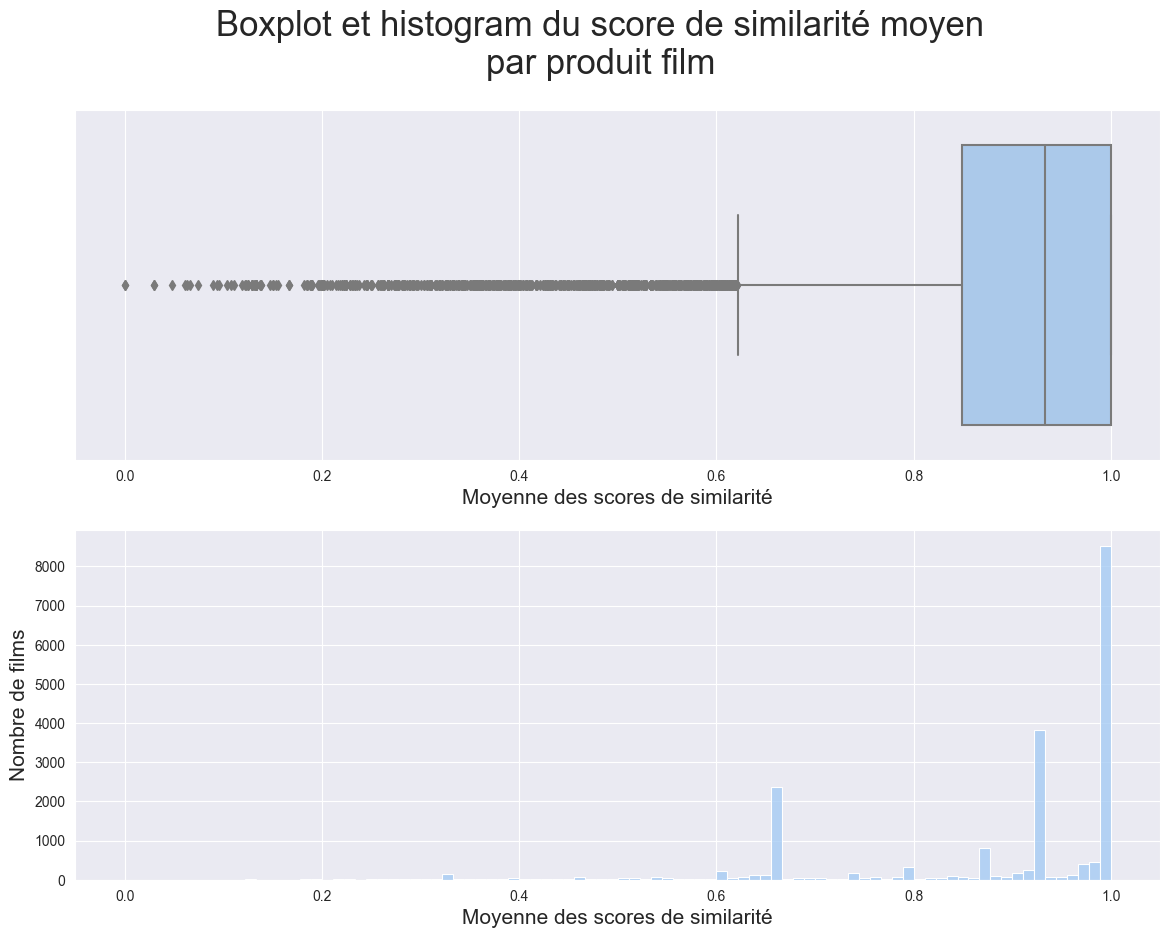

In [18]:
fig, axes = plt.subplots(2,1, figsize=(14,10))

#Nombre d'ingrédients maximum pour un seul produit : 
ax=axes[0]

sns.boxplot(data= df, x="score_mean", ax=ax)
ax.set_xlabel("Moyenne des scores de similarité", fontsize=15)
#ax.set_title("Boxplot du nombre d'ingrédients par produit\n", fontsize=25)


ax=axes[1]
sns.histplot(data=df, x="score_mean",ax=ax)
#ax.set_title("Histogramme du nombre d'ingrédients par produit\n", fontsize=25)
ax.set_xlabel("Moyenne des scores de similarité",fontsize=15)
ax.set_ylabel("Nombre de films", fontsize=15)

#plt.tight_layout()
plt.suptitle("Boxplot et histogram du score de similarité moyen\npar produit film", fontsize=25)
plt.show()

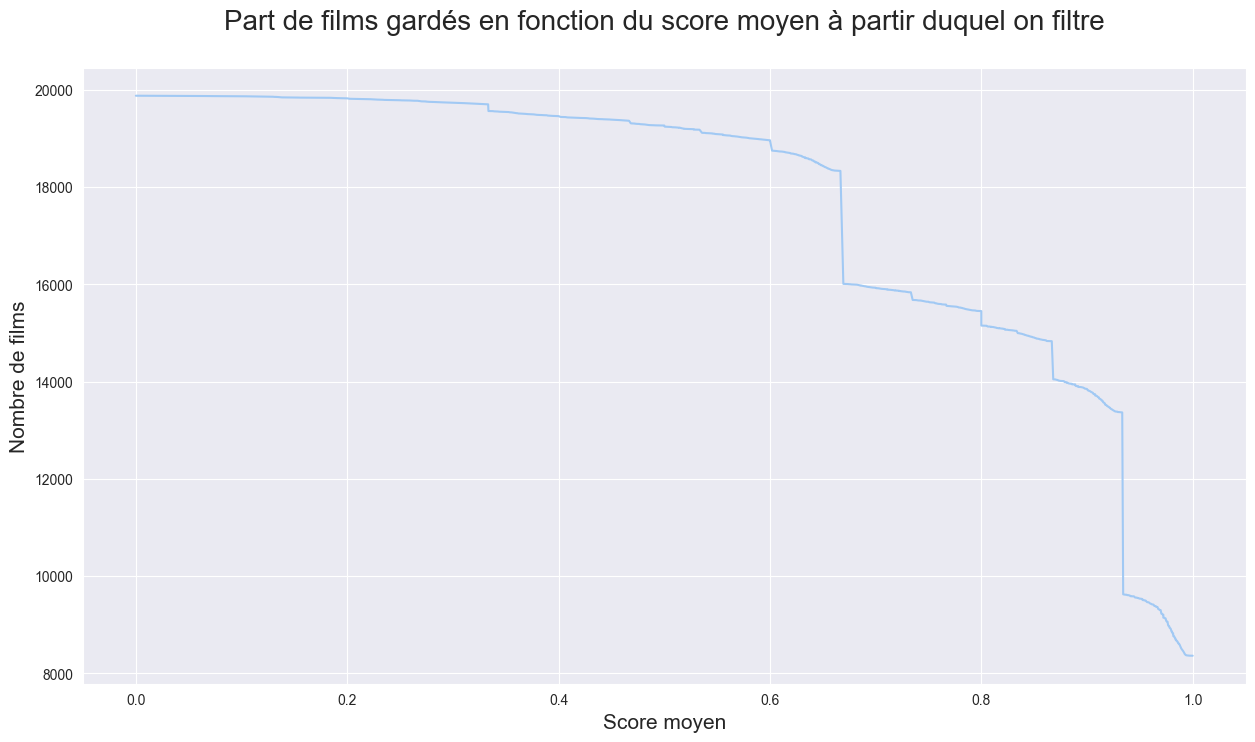

In [19]:
temp = df.groupby("score_mean").agg("count").reset_index().sort_values("score_mean",ascending=False)[["score_mean","id"]]
temp["Somme_cummulee"]= temp["id"].cumsum()

sns.lineplot(data=temp,x="score_mean",y="Somme_cummulee")
plt.xlabel("Score moyen",fontsize=15)
plt.ylabel("Nombre de films",fontsize=15)
plt.title("Part de films gardés en fonction du score moyen à partir duquel on filtre\n",fontsize=20)
plt.show()

In [23]:
seuil = 0.66
print(f"Nombre de films pour un seuil de {seuil} :", len(df[df["score_mean"]>seuil]))

Nombre de films pour un seuil de 0.66 : 18344


In [24]:
#Filtre : 
df = df[df["score_mean"]>0.66]

In [25]:
check_nan(df)
print()
check_unique(df)
df.shape

Valeurs nan dans id : 0
Valeurs nan dans title : 0
Valeurs nan dans sc_id : 0
Valeurs nan dans sc_rating : 1000
Valeurs nan dans sc_detailed_similarity : 0
Valeurs nan dans score_mean : 0

Valeurs uniques dans id : 18344
Valeurs uniques dans title : 17606
Valeurs uniques dans sc_id : 18281
Valeurs uniques dans sc_rating : 72
Valeurs uniques dans sc_detailed_similarity : 887
Valeurs uniques dans score_mean : 635


(18344, 6)

# Sauvegarde des données 

In [28]:
df.to_csv(data_path+"Senscritique_ids_notes_cleaned.csv",index=False)

In [8]:
#INITIALIZATION
driver = webdriver.Chrome()
driver.get("https://www.senscritique.com/search?filters%5B0%5D%5Bidentifier%5D=universe&filters%5B0%5D%5Bvalue%5D=Films&size=16")
cookies_box = find_on_page('//*[@id="didomi-notice-agree-button"]')
cookies_box.click()
movie_ids = []
movie_ratings = []
mean_similarity_scores = []
detailed_similarity_scores = []
new_first_id = 'fight_club/363185'
last_first_id = 'fight_club/363185'

#GET MOVIE IDS AND RATINGS
for i_titre in range(len(titres[0:10])):
    new_id = None
    rating = None
    search_box = find_on_page('//*[@id="search"]')
    search_box.send_keys(Keys.CONTROL + "A")
    search_box.send_keys(Keys.BACK_SPACE)
    search_box.send_keys(titres[i_titre])
    search_box.send_keys(Keys.ENTER)
    while new_first_id == last_first_id:
        try:
            movie_link = find_on_page('//*[@id="__next"]/div[1]/main/div[1]/div/div[2]/div[5]/div[1]/div[2]/h3/a')
            new_first_id = "/".join(movie_link.get_attribute('href').split('/')[-2:])
        except:
            pass
    last_first_id = new_first_id
    movie_container_results = driver.find_elements(By.CSS_SELECTOR, "div[class='ExplorerProductCard__Container-sc-1fw1q8r-0 gkhVSD']")
    detailed_scores = []
    similarity_scores = []
    rates = []
    for i in range(len(movie_container_results)):
        div = movie_container_results[i]        
        try :
            title_element = div.find_element(By.CSS_SELECTOR, "a[class='Text__SCText-sc-kgt5u3-0 Link__SecondaryLink-sc-1vfcbn2-1 jbJnwO eDKWEX']")
            title = title_element.text
        except :
            title = ""
        try:
            rating_element = div.find_element(By.CSS_SELECTOR, "*[data-testid='Rating']")
            rate = float(rating_element.text)
        except:
            rate = np.NAN
        try :
            desc_element = div.find_element(By.CSS_SELECTOR, "p[data-testid='product-explorer-creator']")
            desc = desc_element.text
        except:
            desc = "Film"
        desc = desc.split(' · ')
        if len(desc) == 2:
            date = int(desc[1])
        else:
            date = -1000
        desc = desc[0].split('Film de ')
        if len(desc) == 2:
            producers = desc[1].split(', ')
        else:
            producers = []
        detailed_score = score_similarite(titres[i_titre], dates[i_titre], reals[i_titre], title, date, producers)
        mean_score = detailed_score[3]
        detailed_scores.append(detailed_score)
        similarity_scores.append(mean_score)
        rates.append(rate)     
    container = movie_container_results[np.argmax(similarity_scores)]
    movie_link = container.find_element(By.CSS_SELECTOR, "a[class='Text__SCText-sc-kgt5u3-0 Link__SecondaryLink-sc-1vfcbn2-1 jbJnwO eDKWEX']")
    new_id = "/".join(movie_link.get_attribute('href').split('/')[-2:])
    movie_ids.append(new_id)
    rating = rates[np.argmax(similarity_scores)]
    movie_ratings.append(rating)
    
print(movie_ids)
print(movie_ratings)



NameError: name 'score' is not defined

In [ ]:
%%time
nb_drivers = 1
nb_films_by_iter =100
nb_movies= len(movie_csv)

ids_movies_by_drivers = init_movies_by_driver(nb_drivers, nb_movies)
nb_iterations =(nb_movies//(nb_drivers*nb_films_by_iter))+1
init_save_files(nb_drivers)

#Nombre de fois que les drivers vont se lancer et se fermer
for j in range(nb_iterations) : 
    print("Itération :",j)
    with futures.ThreadPoolExecutor() as executor: 
        future_results = [ executor.submit(workload_driver,{'id':i, 'index_start' :ids_movies_by_drivers[i]["start"]+nb_films_by_iter*j , 'index_end':ids_movies_by_drivers[i]["end"]})  for i in range(nb_drivers) ] 
        for future_result in future_results: 
            try:
                future_result = future_result.result()
            except Exception as exc: # can give a exception in some thread, but 
                print("thread generated an exception",exc)
                break; # can use `timeout` to wait max seconds for each thread               

#Concaténation et enregirstrement des données
df_movies=pd.DataFrame()
for i in range(nb_drivers): 
    df_movies=pd.concat([df_movies, pd.read_csv(f"./sens_critique_csv/cast_movies_{i}.csv")])
df_movies.to_csv(f"./sens_critique_csv/_casting_movies.csv",index=False)

Itération : 0
salut


In [ ]:
#GET REVIEWS IDS
for _id in movie_ids:
    print(movie_ids.index(_id) + ' / ' + len(movie_ids))
    review_ids = []     
    driver.get(f"https:www.senscritique.com/film/{_id}/critiques")
    review_elements = driver.find_elements(By.LINK_TEXT, "Lire la critique")
    review_ids = [review_element.get_attribute('href').split('/')[-1] for review_element in review_elements]
    for i in range(9):
        try:
            next_page = driver.find_elements(By.CSS_SELECTOR, f"span[data-testid='click-{i+2}']")[0]
        except:
            #print(f'FAILED AT FINDING {i+2}')
            break
        driver.execute_script("window.scrollTo(0, 400)")
        time.sleep(.3)
        next_page.click()
        #print("passing")
        while all(item in review_elements for item in driver.find_elements(By.LINK_TEXT, "Lire la critique")):
            pass
        #print("found")
        review_elements = driver.find_elements(By.LINK_TEXT, "Lire la critique")
        for element in review_elements:
            if element.get_attribute('href').split('/')[-1] not in review_ids:
                review_ids.append(element.get_attribute('href').split('/')[-1])

    #GET REVIEWS CONTENT
    review_titles = []
    review_authors = []
    review_ratings = []
    review_bodys = []
    for r_id in review_ids:
        response = requests.get(f"https://www.senscritique.com/film/{_id.split('/')[0]}/critique/{r_id}")
        review_soup = BeautifulSoup(response.content, 'html.parser')
        review_title = review_soup.find('h1').text
        review_author = review_soup.find('a', class_='Text__SCText-sc-kgt5u3-0 Username__WrapperUsername-sc-19yskas-1 hrLruW').text
        review_rating = int(review_soup.find('div', class_='Rating__UserRating-sc-1rkvzid-2 fylBAF').text)
        review_body = review_soup.find('div', class_='Content__Container-sc-1a6ct0l-0 kJVhmZ').text
        review_titles.append(review_title)
        review_authors.append(review_author)
        review_ratings.append(review_rating)
        review_bodys.append(review_body)
    reviews.append([review_ids, review_titles, review_authors, review_ratings, review_bodys])

In [101]:
ids, ratings, reviews

(['avatar_la_voie_de_l_eau/450676',
  'les_banshees_d_inisherin/41368328',
  'tempete/16273897',
  'm3gan/44804275',
  'le_tourbillon_de_la_vie/47794530',
  'tirailleurs/45177319',
  'avatar/371239',
  'glass_onion_une_histoire_a_couteaux_tires/41075361',
  'le_parfum_vert/45440633',
  'le_chat_potte_2_la_derniere_quete/11528908',
  'avatar_la_voie_de_l_eau/450676',
  'les_banshees_d_inisherin/41368328',
  'tempete/16273897',
  'm3gan/44804275',
  'le_tourbillon_de_la_vie/47794530',
  'tirailleurs/45177319',
  'avatar/371239',
  'glass_onion_une_histoire_a_couteaux_tires/41075361',
  'le_parfum_vert/45440633',
  'le_chat_potte_2_la_derniere_quete/11528908'],
 [6.9, 7.3, 6.2, 5.4, 6.2, 5.7, 6.4, 6.3, 5.7, 7.3],
 [])